# Symmetric vs asymmetric parcellation


In [9]:
import sys
sys.path.append("..")
import ProbabilisticParcellation.evaluate as ev
import ProbabilisticParcellation.util as ut
import ProbabilisticParcellation.export_atlas as ea
import ProbabilisticParcellation.scripts.parcel_hierarchy as ph
import ProbabilisticParcellation.scripts.evaluate_atlas as eva
import ProbabilisticParcellation.scripts.symmetry as sym
import hierarchical_clustering as cl
import Functional_Fusion.dataset as ds
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sb
import pandas as pd
import torch as pt
import os
import SUITPy as suit
import numpy as np
import Functional_Fusion.atlas_map as am
from matplotlib.colors import ListedColormap
import nitools as nt
import seaborn as sb
import nibabel as nb
import json


In [2]:
figsize = (20, 20)
model_pair = [
        "Models_03/NettekovenSym32_space-MNISymC2",
        "Models_03/NettekovenAsym32_space-MNISymC2",
    ]


atlas = 'MNISymC2'

# Figure settings
figsize = (8, 8)
colorbar = True
bordersize = 4
dtype = 'func'
cmap = 'inferno'
cscale = (0.5, 1)
labels = None

background = 'white'
if background == 'black':
    fontcolor = 'w'
    bordercolor = 'w'
    backgroundcolor = 'k'
elif background == 'white':
    fontcolor = 'k'
    bordercolor = 'k'
    backgroundcolor = 'w'

# Group Symmetry

## Boundary Asymmetry (Group)


In [4]:
# Read in individual and group correlation
asym_sym_corr_group = np.load(f'{ut.model_dir}/Models/{model_pair[0]}_asym_sym_corr_group.npy')
asym_sym_corr_group = asym_sym_corr_group[1, :]
# Set middle to nan
suit_atlas, _ = am.get_atlas(atlas, ut.base_dir + "/Atlases")
indx_middle = np.where(suit_atlas.world[0, :] == 0)[0]
# Set middle to nan
asym_sym_corr_group[indx_middle] = np.nan

## Data-based (Data vector cosine similarity)

In [5]:
sym_score = np.load(
    f'{ut.model_dir}/Models/Evaluation/nettekoven_68/functional_sim_data.npy')
sym_score_avg = np.nanmean(
    sym_score, axis=0).squeeze().astype(float)
# Set middle to nan
sym_score_avg[indx_middle] = np.nan
sym_score[:, indx_middle] = np.nan

Nifti = suit_atlas.data_to_nifti(sym_score_avg)
sym_score_avg_surf = suit.flatmap.vol_to_surf(Nifti, stats='nanmean',
                                              space='MNISymC', ignore_zeros=False)


In [6]:
# Datasetwise average

# Load number of participants
T = pd.read_csv(ut.base_dir + '/dataset_description.tsv', sep='\t')
n_subjects = T.num_particpants[:7].values
# Make index start at 0
sub_cumulative = np.cumsum(n_subjects) - 1
# print(sub_cumulative)

# Loop through n_subjects and group correlation by dataset
functional_sim_dataset = []
for i in range(len(n_subjects)):
    # print subjects to average to check subject indexing is correct
    if i == 0:
        # print(sub_cumulative[i])
        functional_sim_dataset.append(
            np.nanmean(sym_score[:sub_cumulative[i]], axis=0))
    else:
        # print(sub_cumulative[i-1]+1, sub_cumulative[i])
        functional_sim_dataset.append(
            np.nanmean(sym_score[sub_cumulative[i - 1] + 1:sub_cumulative[i]], axis=0))


/var/folders/y1/13zjm1t50ms6ds24c69y7vx40000gn/T/ipykernel_22424/808781022.py:17: RuntimeWarning: Mean of empty slice
  np.nanmean(sym_score[:sub_cumulative[i]], axis=0))
/var/folders/y1/13zjm1t50ms6ds24c69y7vx40000gn/T/ipykernel_22424/808781022.py:21: RuntimeWarning: Mean of empty slice
  np.nanmean(sym_score[sub_cumulative[i - 1] + 1:sub_cumulative[i]], axis=0))


<Axes: >

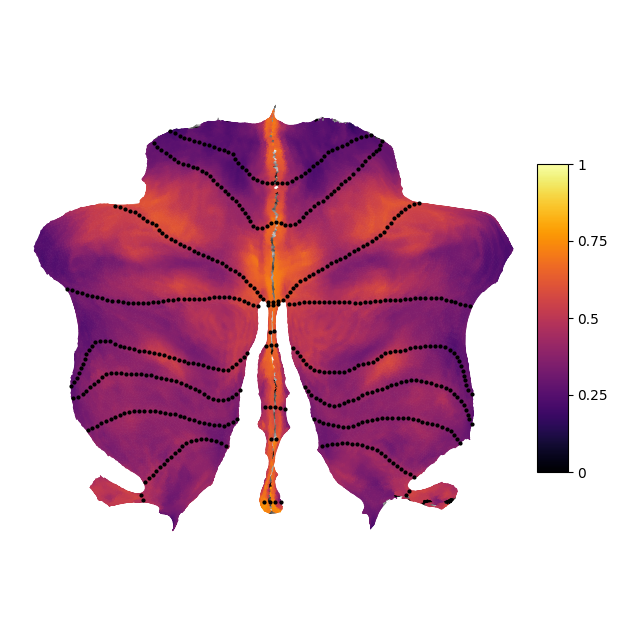

In [7]:
# Plot the symmetry map
plt.figure(figsize=figsize)
suit.flatmap.plot(sym_score_avg_surf,
                  render='matplotlib',
                  overlay_type='func',
                  new_figure=False,
                  cmap=cmap,
                  bordercolor=bordercolor,
                  backgroundcolor=backgroundcolor,
                  bordersize=bordersize,
                  colorbar=colorbar,
                  cscale=(0, 1))
# plt.savefig(ut.figure_dir + 'Symmetry_functional_individual.png',
#             dpi=300, bbox_inches='tight')

In [ ]:
functional_sim_dataset_surf = []
for d, dset in enumerate(T.name[:-1].values):
    Nifti = suit_atlas.data_to_nifti(functional_sim_dataset[d])
    functional_sim_dataset_surf.append(suit.flatmap.vol_to_surf(Nifti, stats='nanmean',
                                                           space='MNISymC', ignore_zeros=False))
    


## Silas Busch Paper: Functional Symmetry by Lobule

In [50]:
# Import lobular parcellation
with open(ut.atlas_dir + '/atlas_description.json', 'r') as f:
        T = json.load(f)
space_dir = T[atlas]['dir']
space_name = T[atlas]['space']

lobs = nb.load(ut.atlas_dir +
                      f'/{space_dir}/atl-Anatom_space-{space_name}_dseg.nii')

# Resample lobules to MNISymC2 space
lobs = suit_atlas.read_data(lobs, interpolation = 0)

# Imprt lobules info
info_file = '/Applications/spm12/toolbox/suit/atlasesSUIT/Lobules-SUIT.nii.lut'
lobules_info = pd.read_csv(info_file, sep=' ', header=None)
lobules_info.dropna(axis=1, inplace=True) # drop blank columns
lobules_info.columns = ['lobule_index', 'r', 'g', 'b', 'lobule_name']
lobules_info['lobule_index'] = lobules_info['lobule_index'].astype(int)-1 # 0-indexing
# Replace lobule_name 'Left_I_IV' with 'Left_I-IV' and 'Right_I_IV' with 'Right_I-IV'
lobules_info['lobule_name'] = lobules_info['lobule_name'].str.replace('I_IV', 'I-IV')
lobules_info['hemisphere'] = lobules_info['lobule_name'].str.split('_').str[0]
lobules_info['lobule'] = lobules_info['lobule_name'].str.split('_').str[1]
lobules_info








,lobule_index,r,g,b,lobule_name,hemisphere,lobule
0,0,0.800,1.000,0.000,Left_I-IV,Left,I-IV
1,1,0.722,0.902,0.000,Right_I-IV,Right,I-IV
2,2,0.000,0.902,0.361,Left_V,Left,V
3,3,0.000,1.000,0.400,Right_V,Right,V
4,4,0.000,0.400,1.000,Left_VI,Left,VI
5,5,0.000,0.322,0.800,Vermis_VI,Vermis,VI
6,6,0.000,0.400,1.000,Right_VI,Right,VI
7,7,0.800,0.000,1.000,Left_CrusI,Left,CrusI
8,8,0.639,0.000,0.800,Vermis_CrusI,Vermis,CrusI
9,9,0.800,0.000,1.000,Right_CrusI,Right,CrusI


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'I-IV'),
  Text(1, 0, 'V'),
  Text(2, 0, 'VI'),
  Text(3, 0, 'CrusI'),
  Text(4, 0, 'CrusII'),
  Text(5, 0, 'VIIb'),
  Text(6, 0, 'VIIIa'),
  Text(7, 0, 'VIIIb'),
  Text(8, 0, 'IX'),
  Text(9, 0, 'X')])

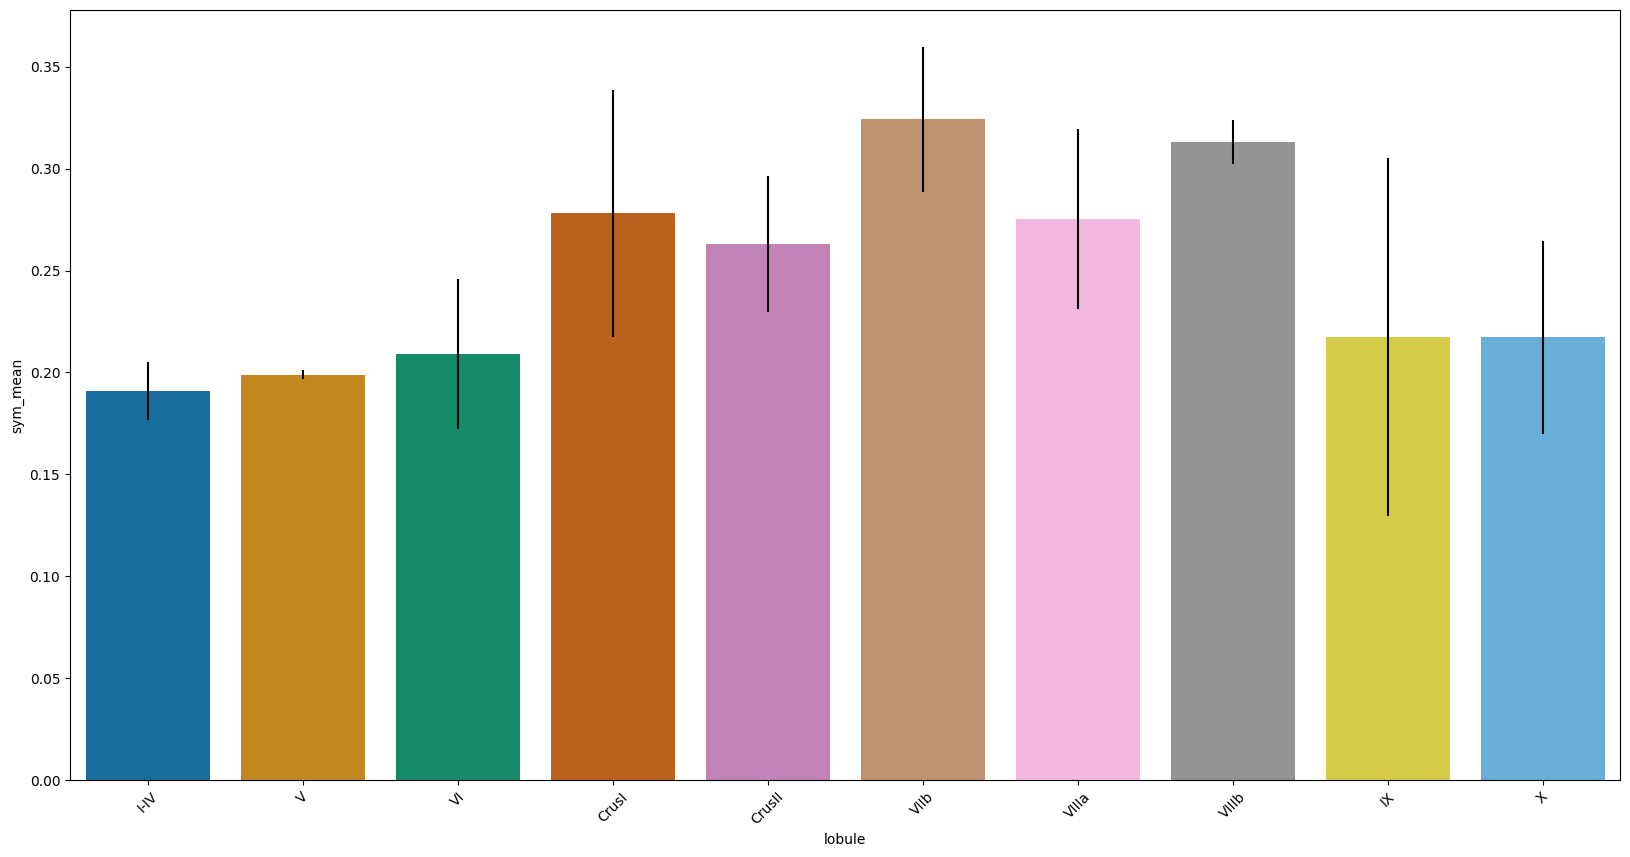

In [56]:

# Collect data
symmetry_lobules = []
# Summarize functional symmetry by lobules (Lobule 5, 6, Crus 1 & Crus 2)
for lobule in lobules_info['lobule'].unique()[:-3]:
    # Select all rows that either contain the left or the right hemisphere of this lobule
    lobule_rows = (lobules_info['lobule'] == lobule) & (lobules_info['hemisphere'] != 'Vermis')
    sym_mean = np.nanmean(sym_score_avg[lobules_info['lobule_index'][lobule_rows].values], axis=0)
    sym_std = np.nanstd(sym_score_avg[lobules_info['lobule_index'][lobule_rows].values], axis=0)
    symmetry_lobules.append([lobule, sym_mean, sym_std])

symmetry_lobules = pd.DataFrame(symmetry_lobules, columns=['lobule', 'sym_mean', 'sym_std'])

# Plot as bar graph with error bars
plt.figure(figsize=(20, 10))
sb.barplot(x='lobule', y='sym_mean', data=symmetry_lobules, yerr=symmetry_lobules['sym_std'], palette='colorblind')
plt.xticks(rotation=45)

